In [1]:
#Load other modules specific to this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rnd
from scipy import signal
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

#Create a print formatting class
class printFormat:
    bold = '\033[1m'
    italic = '\033[3m'
    end = '\033[0m'

!eeggan setup_tutorial

eeggan_training_example.csv has been downloaded and saved to directory data.
eeggan_validation_example.csv has been downloaded and saved to directory data.
pretrained_autoencoder.pt has been downloaded and saved to directory trained_ae.
pretrained_gan.pt has been downloaded and saved to directory trained_models.
EEG-GAN tutorial files have been downloaded.


In [3]:
#Load the data
empiricalHeaders = np.genfromtxt('data/eeggan_training_example.csv', delimiter=',', names=True).dtype.names
empiricalEEG = np.genfromtxt('data/eeggan_training_example.csv', delimiter=',', skip_header=1)

#Print the head of the data
print(printFormat.bold + 'Display Header and first few rows/columns of data\n \033[0m' + printFormat.end)
print(pd.DataFrame(empiricalEEG, columns=empiricalHeaders).iloc[:5,:6])

#Print some information about the columns
print('\n' + '-'*90)
print(f"{printFormat.bold}\nNote the first four columns:{printFormat.end}\n"
      f"    ParticipantID - Indicates different participants\n"
      f"    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified\n"
      f"    Trial - Indicates the trial number for that participant and condition\n"
      f"    Electrode - a numerical number ID of each electrode")
print('\nThe remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.\n'
      'The samples span from -200 to 1000ms around the onset of a feedback stimulus.\n'
      'These are downsampled from the original data, which contained 600 datapoints per sample.')

# Print some meta-data
print('\n' + '-'*90)
print(f"\n{printFormat.bold}Other characteristics of our data include:{printFormat.end}")
print(f"-We have {len(set(empiricalEEG[:,0]))} participants in our training set")
average_trials = round(np.mean([np.max(empiricalEEG[empiricalEEG[:,0] == pID, 2]) for pID in set(empiricalEEG[:,0])]))
std_trials = round(np.std([np.max(empiricalEEG[empiricalEEG[:,0] == pID, 2]) for pID in set(empiricalEEG[:,0])]))
print(f"-Participants have an average of {average_trials} (SD: {std_trials}) trials per outcome (win, lose)")
print(f"-There are a total of {len(empiricalEEG)} samples in our data")
print(f"-There is {len(set(empiricalEEG[:,3]))} electrode in our data")

Display Header and first few rows/columns of data
 
   ParticipantID  Condition  Trial  Electrode      Time1      Time2
0           12.0        0.0    1.0        1.0   3.457978   4.117102
1           12.0        0.0    2.0        1.0 -14.463714 -13.335952
2           12.0        0.0    3.0        1.0   6.562403   9.021622
3           12.0        0.0    4.0        1.0  -4.326536  -0.771954
4           12.0        0.0    5.0        1.0   1.140865   9.707995

------------------------------------------------------------------------------------------

Note the first four columns:
    ParticipantID - Indicates different participants
    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified
    Trial - Indicates the trial number for that participant and condition
    Electrode - a numerical number ID of each electrode

The remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.
The samples span from -200 to 1000ms around the onset of a feedback

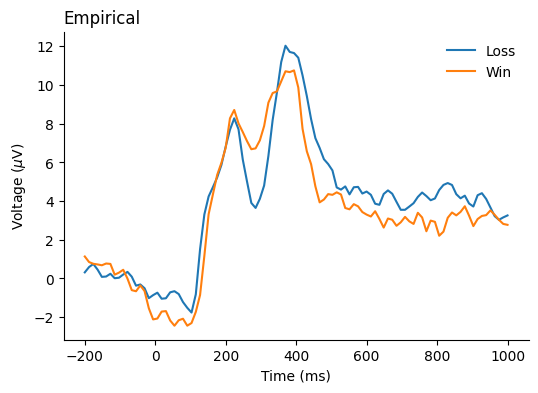

In [4]:
#Determine which rows are each condition
lossIndex = np.where(empiricalEEG[:,1]==1)
winIndex = np.where(empiricalEEG[:,1]==0)

#Grand average the waveforms for each condition
lossWaveform = np.mean(empiricalEEG[lossIndex,4:],axis=1)[0]
winWaveform = np.mean(empiricalEEG[winIndex,4:],axis=1)[0]

#Determine x axis of time
time = np.linspace(-200,1000,100)

#Setup figure
f, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

#Plot each waveform
ax1.plot(time, lossWaveform, label = 'Loss')
ax1.plot(time, winWaveform, label = 'Win')

#Format plot
ax1.set_ylabel('Voltage ($\mu$V)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Empirical', loc='left')
ax1.spines[['right', 'top']].set_visible(False)
ax1.legend(frameon=False)

In [5]:
# Train Autoencoder Parameters
data = 'data/eeggan_training_example.csv'
save_name = 'my_autoencoder.pt'
kw_channel = 'Electrode'
target = 'time'
time_out = 50
n_epochs = 10
seed = 42

# Train the Autoencoder
!eeggan autoencoder_training data={data} save_name={save_name} kw_channel={kw_channel} target={target} time_out={time_out} n_epochs={n_epochs} seed={seed}


-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: data/eeggan_training_example.csv
Model save name: my_autoencoder.pt
Channel label: Electrode
Target: time
Encoded time series size: 50
Number of epochs: 10
Manual seed: True
-----------------------------------------

Managing checkpoints...
Checkpoint saved to trained_ae\checkpoint.pt.
Training complete in: 00:00:02
Training finished.
Checkpoint saved to trained_ae\my_autoencoder.pt.
Training complete in: 00:00:02
Model and configuration saved in trained_ae\my_autoencoder.pt



100%|██████████| 10/10 [00:02<00:00,  3.67it/s, TRAIN LOSS: 0.022877, TEST LOSS: 0.008984]


In [6]:
#Train AE-GAN Parameters
data = 'data/eeggan_training_example.csv'
save_name = 'my_aegan.pt'
autoencoder = 'trained_ae/pretrained_autoencoder.pt' #Uses the pretrained autoencoder
kw_conditions = 'Condition'
kw_channel = 'Electrode'
patch_size = 10
n_epochs = 10
seed = 42

# Train the AE-GAN on CPUs
!eeggan gan_training data={data} autoencoder={autoencoder} save_name={save_name} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}


-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: data/eeggan_training_example.csv
Using autoencoder: trained_ae/pretrained_autoencoder.pt
Model save name: my_aegan.pt
Conditions: ['Condition']
Channel label: Electrode
Patch size: 10
Number of epochs: 10
Manual seed: True
Generator and discriminator initialized.

-----------------------------------------
Training GAN...
-----------------------------------------

Managing checkpoints...
Checkpoint saved to trained_models\checkpoint.pt.
Training complete in: 00:00:16
Checkpoint saved to trained_models\my_aegan.pt.
Training complete in: 00:00:16
GAN training finished.



100%|██████████| 10/10 [00:16<00:00,  1.68s/it, D LOSS: -0.725763, G LOSS: 2.004391]


In [7]:
#Train GAN Parameters
data = 'data/eeggan_training_example.csv'
save_name = 'my_gan.pt'
kw_conditions = 'Condition'
kw_channel = 'Electrode'
patch_size = 10
n_epochs = 10
seed = 42

# Train the GAN on CPUs
!eeggan gan_training data={data} save_name={save_name} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}


-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: data/eeggan_training_example.csv
Model save name: my_gan.pt
Conditions: ['Condition']
Channel label: Electrode
Patch size: 10
Number of epochs: 10
Manual seed: True
Generator and discriminator initialized.

-----------------------------------------
Training GAN...
-----------------------------------------

Managing checkpoints...
Checkpoint saved to trained_models\checkpoint.pt.
Training complete in: 00:00:24
Checkpoint saved to trained_models\my_gan.pt.
Training complete in: 00:00:24
GAN training finished.



100%|██████████| 10/10 [00:24<00:00,  2.49s/it, D LOSS: 2.998791, G LOSS: -1.095415]


In [8]:
!eeggan visualize loss model=trained_models/pretrained_gan.pt
!eeggan visualize average model=trained_models/pretrained_gan.pt

print(f"\n{printFormat.bold}Note Google Collab does not support plotting from an executable like this. So, to see the loss plots you will need to run it on another environment, such as locally using CLI.{printFormat.end}")


-----------------------------------------
Command line arguments:
-----------------------------------------

Plotting training loss
Using samples from model/checkpoint file (.pt)trained_models/pretrained_gan.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting losses...
Figure(640x480)

-----------------------------------------
Command line arguments:
-----------------------------------------

Averaging over all samples
Using samples from model/checkpoint file (.pt)trained_models/pretrained_gan.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting averaged curves over each set of conditions...
Figure(640x480)

Note Google Collab does not support plotting from an executable like this. So, to see the loss plots you will need to run it on another environment, such as locally using CLI.


In [9]:
!eeggan generate_samples model=trained_models/pretrained_gan.pt conditions=0 save_name=aegan_data_c0.csv seed=42
!eeggan generate_samples model=trained_models/pretrained_gan.pt conditions=1 save_name=aegan_data_c1.csv seed=42


-----------------------------------------
Command line arguments:
-----------------------------------------

File: trained_models/pretrained_gan.pt
Conditions: [0]
Saving generated samples to file: aegan_data_c0.csv
Manual seed: True

-----------------------------------------
System output:
-----------------------------------------

Initializing generator...
Generating samples...
Generating sequence 1/20...
Generating sequence 2/20...
Generating sequence 3/20...
Generating sequence 4/20...
Generating sequence 5/20...
Generating sequence 6/20...
Generating sequence 7/20...
Generating sequence 8/20...
Generating sequence 9/20...
Generating sequence 10/20...
Generating sequence 11/20...
Generating sequence 12/20...
Generating sequence 13/20...
Generating sequence 14/20...
Generating sequence 15/20...
Generating sequence 16/20...
Generating sequence 17/20...
Generating sequence 18/20...
Generating sequence 19/20...
Generating sequence 20/20...
Saving samples...
Generated samples were save

In [10]:
#Load Data
syntheticHeaders = np.genfromtxt('generated_samples/aegan_data_c0.csv', delimiter=',', names=True).dtype.names
gan_c0 = np.genfromtxt('generated_samples/aegan_data_c0.csv', delimiter=',', skip_header=1)
gan_c1 = np.genfromtxt('generated_samples/aegan_data_c1.csv', delimiter=',', skip_header=1)
syntheticEEG = np.concatenate((gan_c0,gan_c1),axis=0)

#Print head of the data
print(f"{printFormat.bold}Display first few rows/columns of data{printFormat.end}")
print(pd.DataFrame(syntheticEEG, columns=syntheticHeaders).iloc[:5,:6])

# Print condition sample counts
print(f"\n{printFormat.bold}Display trial counts for each condition{printFormat.end}")
print(f"{printFormat.bold}Win: {printFormat.end}{np.sum(syntheticEEG[:, 0] == 0)}")
print(f"{printFormat.bold}Lose: {printFormat.end}{np.sum(syntheticEEG[:, 0] == 1)}")

Display first few rows/columns of data
   Condition  Electrode     Time0     Time1     Time2     Time3
0        0.0        1.0  0.389140  0.408398  0.384589  0.297453
1        0.0        1.0  0.352499  0.332882  0.484594  0.577283
2        0.0        1.0  0.520258  0.509756  0.543827  0.580087
3        0.0        1.0  0.467429  0.476422  0.493830  0.487191
4        0.0        1.0  0.457286  0.488315  0.514131  0.466328

Display trial counts for each condition
Win: 1000
Lose: 1000


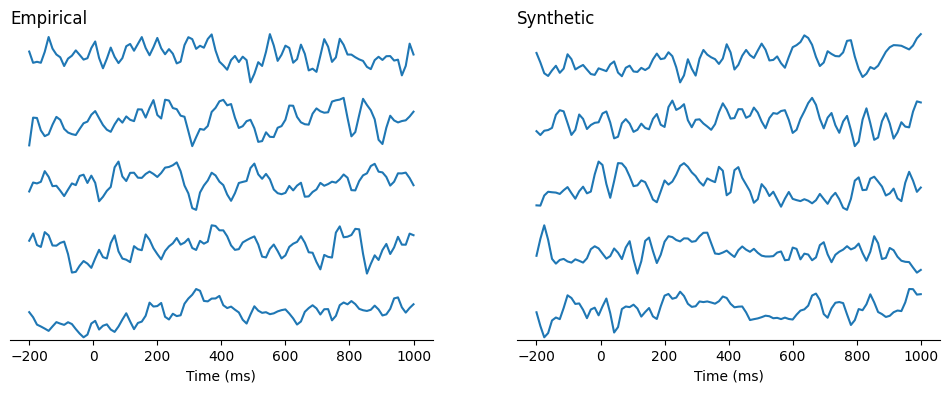

In [21]:
#Determine 5 random trials to plot
empiricalIndex = rnd.sample(range(0, empiricalEEG.shape[0]), 5)
syntheticIndex = rnd.sample(range(0, syntheticEEG.shape[0]), 5)

#Plot trial data
f, ax = plt.subplots(5, 2, figsize=(12, 4))
for c in range(5):
    ax[c,0].plot(time,empiricalEEG[empiricalIndex[c],4:]) #Note, we here add the same filter simply for visualization
    ax[c,0].set_yticks([])

    ax[c,1].plot(time,syntheticEEG[syntheticIndex[c],2:])
    ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
    ax[c,1].set_yticks([])

    if c == 0:
        ax[c,0].set_title('Empirical', loc='left')
        ax[c,1].set_title('Synthetic', loc='left')
    else:
        ax[c,0].set_title(' ')
        ax[c,1].set_title(' ')

    if c != 4:
        ax[c,0].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xticks([])
        ax[c,1].set_xticks([])
    else:
        ax[c,0].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xlabel('Time (ms)')
        ax[c,1].set_xlabel('Time (ms)')